# Use Tensorflow to recognize hand-written digits with `ibm-watson-machine-learning`
This notebook contains the steps and code to demonstrate support of Deep Learning model training and scoring in the Watson Machine Learning service. It introduces commands for data retrieval, `training_definition` persistance to Watson Machine Learning repository, model training, model persistance, model deployment and scoring.

Some familiarity with [Python](https://cognitiveclass.ai/courses/python-for-data-science) is helpful. This notebook uses Python 3.6.

## Learning goals
The learning goals of this notebook are:
-  Working with Watson Machine Learning service.
-  Training Deep Learning models (TensorFlow).
-  Saving trained models in Watson Machine Learning repository.
-  Online deployment and scoring of trained model.

## Contents
This notebook contains the following parts:
1.	[Setup](#setup)
2.	[Create model definition](#model_df)
3.	[Train model](#training)
4.  [Persist trained model](#persist)
5.	[Deploy and Score](#deploy)
6.  [Clean up](#clean)
7.	[Summary and next steps](#summary)

<a id="setup"></a>
## 1. Set up the environment

<img src="https://s3.us.cloud-object-storage.appdomain.cloud/docs-resources/hmac-credential-dialog.jpg" width="700" align="right" alt="Creating a COS service credential"/>
Before you use the sample code in this notebook, you must perform the following setup tasks:

1.  Create a [Watson Machine Learning (WML) Service](https://cloud.ibm.com/catalog/services/machine-learning) instance (a free plan is offered and information about how to create the instance is [here](https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/wml-setup.html))
1. Create a [Cloud Object Storage (COS)](https://cloud.ibm.com/catalog/services/cloud-object-storage) instance (a lite plan is offered and information about how to order storage is [here](https://cloud.ibm.com/docs/cloud-object-storage/basics/order-storage.html)).
1. Create a service credential for the COS instance.
    - In the **Service credentials** tab, click **New credential**.
    - Expand **Advanced options**
    - Click the **Include HMAC Credential** switch to create an [HMAC credential](https://cloud.ibm.com/docs/cloud-object-storage?topic=cloud-object-storage-uhc-hmac-credentials-main)
    - Click **Add**.
    - Beside the new service credential, click **Copy to clipboard**. Use this value for the `cos_credentials` variable below in the second code cell.
1. Get the COS service endpoint:
    - In the COS instance, click the **Endpoints** tab.
    - Under **Select resiliency**, select **Cross Region**.
    - Under **Select location**, select the location of your Watson Studio service instance (e.g. `eu-geo`).
    - Copy the first endpoint under the **Public** column (e.g. `s3.eu.cloud-object-storage.appdomain.cloud`). This value will be appended to `https://` and used in the `service_endpoint` variable, in the third code cell.

### 1.1 Working with Cloud Object Storage
Use the following [libraries/packages](https://cloud.ibm.com/docs/cloud-object-storage?topic=cloud-object-storage-sdk-about) to work with IBM Cloud Object Storage (COS):
* **ibm-cos-sdk**: library allows Python developers to manage Cloud Object Storage (COS). It can be installed from the Python Package Index through `pip install ibm-cos-sdk`.

In [1]:
import ibm_boto3
import json
import os
from ibm_botocore.client import Config

Replace the value after the '=' sign in the following cell with your COS credentials that you copied above. 
You can find these credentials in your COS instance dashboard under the **Service credentials** tab.

In [2]:
cos_credentials = {
  "apikey": "***",
  "cos_hmac_keys": {
    "access_key_id": "***",
    "secret_access_key": "***"
  },
  "endpoints": "https://control.cloud-object-storage.cloud.ibm.com/v2/endpoints",
  "iam_apikey_description": "***",
  "iam_apikey_name": "Service credentials-1",
  "iam_role_crn": "***",
  "iam_serviceid_crn": "***",
  "resource_instance_id": "***"
}

In [3]:
api_key = cos_credentials['apikey']
service_instance_id = cos_credentials['resource_instance_id']
auth_endpoint = 'https://iam.cloud.ibm.com/identity/token'
service_endpoint = 'https://' + 's3.eu.cloud-object-storage.appdomain.cloud'

Create COS resource to be able to write data to Cloud Object Storage.

In [5]:
cos = ibm_boto3.resource('s3',
                         ibm_api_key_id=api_key,
                         ibm_service_instance_id=service_instance_id,
                         ibm_auth_endpoint=auth_endpoint,
                         config=Config(signature_version='oauth'),
                         endpoint_url=service_endpoint)

Create the buckets (they have to have unique names) that are used to store training data and training results.

In [6]:
from uuid import uuid4

bucket_uid = str(uuid4())
buckets = ['training-data-' + bucket_uid, 'training-results-' + bucket_uid]

for bucket in buckets:
    if not cos.Bucket(bucket) in cos.buckets.all():
        print('Creating bucket "{}"...'.format(bucket))
        try:
            cos.create_bucket(Bucket=bucket)
        except ibm_boto3.exceptions.ibm_botocore.client.ClientError as e:
            print('Error: {}.'.format(e.response['Error']['Message']))

Creating bucket "training-data-0378f0c4-1021-47f3-b120-52bf330a41d6"...
Creating bucket "training-results-0378f0c4-1021-47f3-b120-52bf330a41d6"...


Now you have 2 buckets.
### 1.2 Downloading training data and upload it to COS buckets.
Download the training data and upload them to the 'training-data' bucket.
Create the list of links for training dataset.

In [7]:
data_links = ['http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz',
              'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz',
              'http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz',
              'http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz']

The following code snippet uploads files from the links to your Cloud Object Storage.

In [8]:
from urllib.request import urlopen

# The training data bucket
bucket_obj = cos.Bucket(buckets[0])

for data_link in data_links:
    filename=data_link.split('/')[-1]
    print('Uploading data {}...'.format(filename))
    with urlopen(data_link) as data:
        bucket_obj.upload_fileobj(data, filename)
        print('{} is uploaded.'.format(filename))

Uploading data train-images-idx3-ubyte.gz...
train-images-idx3-ubyte.gz is uploaded.
Uploading data train-labels-idx1-ubyte.gz...
train-labels-idx1-ubyte.gz is uploaded.
Uploading data t10k-images-idx3-ubyte.gz...
t10k-images-idx3-ubyte.gz is uploaded.
Uploading data t10k-labels-idx1-ubyte.gz...
t10k-labels-idx1-ubyte.gz is uploaded.


Let's see the list of all created buckets and their contents.

In [10]:
for bucket_name in buckets:
    print(bucket_name)
    bucket_obj = cos.Bucket(bucket_name)
    for obj in bucket_obj.objects.all():
        print("  File: {}, {:4.2f} kB".format( obj.key, obj.size / 1024 ))

training-data-0378f0c4-1021-47f3-b120-52bf330a41d6
  File: t10k-images-idx3-ubyte.gz, 1610.23 kB
  File: t10k-labels-idx1-ubyte.gz, 4.44 kB
  File: train-images-idx3-ubyte.gz, 9680.10 kB
  File: train-labels-idx1-ubyte.gz, 28.20 kB
training-results-0378f0c4-1021-47f3-b120-52bf330a41d6


The model is ready to be trained.

### 1.3 Connection to WML
To authenticate to the Watson Machine Learning service on IBM Cloud. You need to provide platform `api_key` and instance `location`. You can do this in multiple ways.

1. You can use [IBM Cloud CLI](https://cloud.ibm.com/docs/cli) or [IBM Cloud Shell](https://cloud.ibm.com/shell) to retrieve platform API Key and instance location.
   * If you are using IBM Cloud CLI, run the `ibmcloud login` or `ibmcloud login --sso` command to login to IBM Cloud.
   * Run the following command to create an API key called **WML API KEY**: `ibmcloud iam api-key-create "WML API KEY"`
   * Get the value of `API Key` from the output.
   * The location of your WML instance can be retrieved with the following command: `ibmcloud resource service-instance WML_INSTANCE_NAME` (e.g. `ibmcloud resource service-instance "Machine Learning-do"`)
   * Get the value of `location` from the output (e.g. `us-south`).
<img src="https://www.ibm.com/support/knowledgecenter/SSTTDS_11.0.0/com.ibm.ace.icp.doc/icp_createapikey.png" width="800" align="right" alt="Create API key from IBM Cloud Console"/>
2. From IBM Cloud console:
   * You can create API keys as follows:
     * In [IBM Cloud](https://cloud.ibm.com), click Manage > [Access (IAM)](https://cloud.ibm.com/iam) > [API keys](https://cloud.ibm.com/iam/apikeys).
     * Click **Create an IBM Cloud API key**.
     * For the **Name**, enter **WML API KEY**.
     * Copy the value of the API key in a safe place.
   
       For more details about creating API keys, see [Managing user API keys - Creating an API key](https://cloud.ibm.com/docs/account?topic=account-userapikey#create_user_key).
   
   * To get the location of the WML service instance from IBM Cloud site, follow these steps:
     * Browse to [IBM Cloud Resource list](https://cloud.ibm.com/resources)
     * Locate the Location of the WML service instamce.
     * Map the location to the region name here: [Locations for resource deployment](https://cloud.ibm.com/docs/overview?topic=overview-locations#mzr-table) and get the required location from the **Region** column (e.g. **us-south**)

In [18]:
api_key = 'EoLkeiTnHuhK9OHg54vQ7E3w-G2Rmfm1-VJ2yswgKIOv'
location = 'us-south'

In [19]:
wml_credentials = {
    "apikey": api_key,
    "url": 'https://' + location + '.ml.cloud.ibm.com'
}

### Install and import the `ibm-watson-machine-learning` package
**Note:** `ibm-watson-machine-learning` documentation can be found <a href="http://ibm-wml-api-pyclient.mybluemix.net/" target="_blank" rel="noopener no referrer">here</a>.

In [13]:
!pip install -U ibm-watson-machine-learning

     |████████████████████████████████| 1.5MB 9.2MB/s eta 0:00:01
  Found existing installation: ibm-watson-machine-learning 1.0.14
    Uninstalling ibm-watson-machine-learning-1.0.14:
      Successfully uninstalled ibm-watson-machine-learning-1.0.14


In [20]:
from ibm_watson_machine_learning import APIClient

client = APIClient(wml_credentials)

### Working with spaces
* Browse to [Deployment Spaces Dashboard](https://dataplatform.cloud.ibm.com/ml-runtime/spaces).
You need a space where you deploy your work models.
* If you do not have a space, create one:
  * Click **New Deployment Space**
  * Create an empty space
  * Select Cloud Object Storage
  * Select Watson Machine Learning instance and press **Create**
  * Copy `space_id` and paste it below
* If you have a deployment space (from a previous exercise):
  * Click the space name.
  * Click the **Settings** tab.
  * Click the value under **Space ID** to copy it.
  * Paste the deployment space ID in the following code cell.
  
**Tip**: You can also use SDK to prepare the space for your work. More information can be found [here](https://github.com/IBM/watson-machine-learning-samples/blob/master/notebooks/python_sdk/instance-management/Space%20management.ipynb).

In [21]:
space_id = 'PASTE YOUR SPACE ID HERE'

You can use `list` method to print all existing spaces.

In [22]:
client.spaces.list(limit=10)

------------------------------------  ----------------  ------------------------
ID                                    NAME              CREATED
3570d3f2-8595-4e44-9b85-d01336096a49  Exercise 5 Space  2020-09-02T23:03:27.651Z
------------------------------------  ----------------  ------------------------


To be able to interact with all the resources available in Watson Machine Learning, you need to set the **space** which you will be using.

In [23]:
client.set.default_space(space_id)

'SUCCESS'

<a id="model_def"></a>
# 2. Create model definition
### 2.1 Prepare model definition metadata

In [24]:
model_definition_metadata = {
    client.model_definitions.ConfigurationMetaNames.NAME: "Hand-written Digit Recognition",
    client.model_definitions.ConfigurationMetaNames.DESCRIPTION: "Hand-written Digit Recognition",
    client.model_definitions.ConfigurationMetaNames.COMMAND:  "python3 tensorflow_mnist_softmax.py --trainingIters 20",
    client.model_definitions.ConfigurationMetaNames.PLATFORM: {"name": "python", "versions": ["3.6"]},
    client.model_definitions.ConfigurationMetaNames.VERSION: "2.0",
    client.model_definitions.ConfigurationMetaNames.SPACE_UID: space_id
}

### 2.2  Get sample model definition content file from git

In [25]:
!pip install wget
import wget

filename = 'tf-softmax-model.zip'

if os.path.isfile(filename):
    print( filename + ' is already downloaded.' )
else:
    filename = wget.download('https://github.com/IBM/watson-machine-learning-samples/raw/master/definitions/tensorflow/tf-softmax-model.zip')

tf-softmax-model.zip is already downloaded.


### 2.3  Publish model definition

In [26]:
definition_details = client.model_definitions.store(filename, model_definition_metadata)

ApiRequestFailure: Failure during creating new attachment. (POST https://api.dataplatform.cloud.ibm.com/v2/assets/dca5f9af-4b4e-4a54-9c76-02dc777d0483/attachments?version=2020-08-01&space_id=3570d3f2-8595-4e44-9b85-d01336096a49)
Status code: 403, body: {"trace":"1wknp6fa7f0iziasmjxi3jtmd","errors":[{"code":"dependent_service_error","message":"ATTSV3016E: Unable to initialize MultiPart Upload. Root cause: 'NGPDL4023E: Storage Server Exception: status code: '403'  message: 'The AWS Access Key ID you provided does not exist in our records. (Service: S3 API; Status Code: 403; Error Code: InvalidAccessKeyId; Request ID: 61b0f868-6425-482c-a112-06c1155cc410)'  error code: 'InvalidAccessKeyId''"}]}

In [16]:
model_definition_id = client.model_definitions.get_id(definition_details)
print(model_definition_id)

b9a4d7fa-683c-4fac-b79c-59274ae96ff1


#### List model definitions

In [ ]:
client.model_definitions.list(limit=5)

<a id="training"></a>
# 3. Train model

### 3.1 Prepare training metadata

In [17]:
training_metadata = training_metadata = {
   client.training.ConfigurationMetaNames.NAME: "Hand-written Digit Recognition",
    client.training.ConfigurationMetaNames.SPACE_UID: space_id,
    client.training.ConfigurationMetaNames.DESCRIPTION: "Hand-written Digit Recognition",
    client.training.ConfigurationMetaNames.TAGS :[{
      "value": "tags_style_transfer_gogh",
      "description": "dome gogh"
    }],
    client.training.ConfigurationMetaNames.TRAINING_RESULTS_REFERENCE:  {
    "name": "MNIST results",
    "connection": {
            "endpoint_url": service_endpoint,
            "access_key_id": cos_credentials['cos_hmac_keys']['access_key_id'],
            "secret_access_key": cos_credentials['cos_hmac_keys']['secret_access_key']
      },
      "location": {
        "bucket": buckets[0]
      },
    "type": "s3"
  },
  client.training.ConfigurationMetaNames.MODEL_DEFINITION:{
        "id": model_definition_id,
        "command":  "python3 tensorflow_mnist_softmax.py --trainingIters 20",
        "hardware_spec": {
          "name": "K80",
          "nodes": 1
        },
        "software_spec": {
          "name": "tensorflow_1.15-py3.6"
        },
        "parameters": {
          "name": "Hand-written Digit Recognition",
          "description": "Hand-written Digit Recognition"
        }
  },
  client.training.ConfigurationMetaNames.TRAINING_DATA_REFERENCES: [
       {
      "name": "training_input_data",
      "type": "s3",
      "connection": {
        "endpoint_url": service_endpoint,
        "access_key_id": cos_credentials['cos_hmac_keys']['access_key_id'],
        "secret_access_key": cos_credentials['cos_hmac_keys']['secret_access_key']
      },
      "location": {
        "bucket": buckets[1]
      },
      "schema": {
        "id":"idmlp_schema",
        "fields": [
          {
            "name": "text",
            "type": "string"
          }
        ]
      }
    }
  ]
}

### 3.2 Train model in background

In [18]:
training = client.training.run(training_metadata)

### 3.3 Get training id and status

In [19]:
training_id = client.training.get_uid(training)

In [23]:
client.training.get_status(training_id)["state"]

'completed'

### 3.4 Get training details

In [ ]:
training_details = client.training.get_details(training_id)
print(json.dumps(training_details, indent=2))

#### List trainings

In [ ]:
client.training.list(limit=5)

#### Cancel training

You can cancel the training run by calling the method below.  
**Tip**: If you want to delete train runs and results, add `hard_delete=True` as a parameter.

<a id="persist"></a>
# 4. Persist trained model

### 4.1 Download trained model from COS

In [25]:
uid = client.training.get_details(training_id)['entity']['results_reference']['location']['logs']

#### Download model from COS

In [26]:
bucket_name = buckets[0]
bucket_obj = cos.Bucket(bucket_name)

model_path = ""
for obj in bucket_obj.objects.iterator():
    if training_id in obj.key and uid in obj.key and obj.key.endswith(".zip"):
        model_path = obj.key
        break

model_name = model_path.split("/")[-1]
bucket_obj.download_file(model_path, model_name)

#### Unpack model and compress it to tar.gz format

In [27]:
import zipfile
import tarfile

with zipfile.ZipFile(model_name, "r") as zip_ref:
    zip_ref.extractall()

model_name = "model.tar.gz"
with tarfile.open(model_name, "w:gz") as tar:
    for file in ("saved_model.pb", "variables"):
        tar.add(file)

### 4.2 Publish model

In [28]:
software_spec_uid = client.software_specifications.get_uid_by_name('tensorflow_1.15-py3.6')

In [29]:
model_meta_props = {client.repository.ModelMetaNames.NAME: "TF Mnist Model",
                    client.repository.ModelMetaNames.TYPE: "tensorflow_1.15",
                    client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: software_spec_uid
                    }

published_model_details = client.repository.store_model(model='model.tar.gz', meta_props=model_meta_props)
model_uid = client.repository.get_model_uid(published_model_details)

### 4.3 Get model details

In [30]:
model_details = client.repository.get_details(model_uid)
print(json.dumps(model_details, indent=2))

{
  "entity": {
    "software_spec": {
      "id": "2b73a275-7cbf-420b-a912-eae7f436e0bc",
      "name": "tensorflow_1.15-py3.6"
    },
    "type": "tensorflow_1.15"
  },
  "metadata": {
    "created_at": "2020-08-13T07:42:54.543Z",
    "id": "c592b0b8-b07f-4fa7-930f-14a23aed49a8",
    "modified_at": "2020-08-13T07:42:56.860Z",
    "name": "TF Mnist Model",
    "owner": "IBMid-5500067NJD",
    "space_id": "74133c06-dce2-4dfc-b913-2e0dc8efc750"
  }
}


#### List stored models

In [ ]:
client.repository.list_models(limit=5)

<a id="deploy"></a>
# 5. Deploy and score

### 5.1 Create online deployment for published model

You can deploy the stored model as a web service (online) by running the code in the following cell.

In [31]:
deployment = client.deployments.create(model_uid, meta_props={
                                            client.deployments.ConfigurationMetaNames.NAME:"TF Mnist deployment",
                                            client.deployments.ConfigurationMetaNames.ONLINE:{}})

scoring_url = client.deployments.get_scoring_href(deployment)
deployment_uid = client.deployments.get_uid(deployment)



#######################################################################################

Synchronous deployment creation for uid: 'c592b0b8-b07f-4fa7-930f-14a23aed49a8' started

#######################################################################################


initializing
ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='b78beeb5-84b6-4a3b-9abc-a740ad781d9f'
------------------------------------------------------------------------------------------------




### 5.2 Get deployments details

In [32]:
deployments_details = client.deployments.get_details(deployment_uid)
print(json.dumps(deployments_details, indent=2))

{
  "entity": {
    "asset": {
      "id": "c592b0b8-b07f-4fa7-930f-14a23aed49a8"
    },
    "custom": {},
    "hardware_spec": {
      "id": "Not_Applicable",
      "name": "S",
      "num_nodes": 1
    },
    "name": "TF Mnist deployment",
    "online": {},
    "space_id": "74133c06-dce2-4dfc-b913-2e0dc8efc750",
    "status": {
      "online_url": {
        "url": "https://wml-fvt.ml.test.cloud.ibm.com/ml/v4/deployments/b78beeb5-84b6-4a3b-9abc-a740ad781d9f/predictions"
      },
      "state": "ready"
    }
  },
  "metadata": {
    "created_at": "2020-08-13T07:43:03.139Z",
    "id": "b78beeb5-84b6-4a3b-9abc-a740ad781d9f",
    "modified_at": "2020-08-13T07:43:03.139Z",
    "name": "TF Mnist deployment",
    "owner": "IBMid-5500067NJD",
    "space_id": "74133c06-dce2-4dfc-b913-2e0dc8efc750"
  }
}


#### List deployments

In [ ]:
client.deployments.list(limit=5)

### 5.3 Score deployed model

Prepare sample scoring data to score deployed model.

In [ ]:
import wget

dataset_filename='mnist.npz'

if not os.path.isfile(dataset_filename):
    dataset_filename = wget.download('https://github.com/IBM/watson-machine-learning-samples/raw/master/data/mnist/mnist.npz')

In [ ]:
import numpy as np

mnist_dataset = np.load(dataset_filename)
x_test = mnist_dataset['x_test']

In [35]:
image_1 = x_test[0].ravel() / 255
image_2 = x_test[1].ravel() / 255

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt

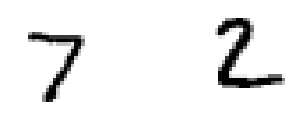

In [38]:
for i, image in enumerate([x_test[0], x_test[1]]):
    plt.subplot(2, 2, i + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')

Build scoring ditionary consisting of two digits and send it to deployed model to get predictions.

In [39]:
scoring_payload = {
    client.deployments.ScoringMetaNames.INPUT_DATA : [
        {'values': [image_1.tolist(), image_2.tolist()]}
    ]
}
scores = client.deployments.score(deployment_uid, meta_props=scoring_payload)
print("Scoring result:\n" + json.dumps(scores, indent=2))

Scoring result:
{
  "predictions": [
    {
      "values": [
        7,
        2
      ]
    }
  ]
}


<a id="clean"></a>
# 6. Clean up

If you want to clean up all created assets:
- experiments
- trainings
- pipelines
- model definitions
- models
- functions
- deployments

please follow up this sample [notebook](https://github.com/IBM/watson-machine-learning-samples/blob/master/notebooks/python_sdk/instance-management/Machine%20Learning%20artifacts%20management.ipynb).

<a id="summary"></a>
# 7. Summary and next steps     

 You successfully completed this notebook! You learned how to use `ibm-watson-machine-learning-client` to train and score TensorFlow models. Check out our [Online Documentation](https://dataplatform.ibm.com/docs/content/analyze-data/wml-setup.html) for more samples, tutorials, documentation, how-tos, and blog posts. 

### Author

**Jan Sołtysik**, Intern in Watson Machine Learning.

Copyright © 2020 IBM. This notebook and its source code are released under the terms of the MIT License.

<div style="background:#F5F7FA; height:110px; padding: 2em; font-size:14px;">
<span style="font-size:18px;color:#152935;">Love this notebook? </span>
<span style="font-size:15px;color:#152935;float:right;margin-right:40px;">Don't have an account yet?</span><br>
<span style="color:#5A6872;">Share it with your colleagues and help them discover the power of Watson Studio!</span>
<span style="border: 1px solid #3d70b2;padding:8px;float:right;margin-right:40px; color:#3d70b2;"><a href="https://ibm.co/wsnotebooks" target="_blank" style="color: #3d70b2;text-decoration: none;">Sign Up</a></span><br>
</div>